In [1]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 60.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 60.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 20.3 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


#Data Pre-processing

In [7]:
# Load the dataset
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

# Create a set of unique characters and build mappings
unique_chars = sorted(set(text))
vocab_size = len(unique_chars)
char_to_idx = {ch: i for i, ch in enumerate(unique_chars)}
idx_to_char = {i: ch for i, ch in enumerate(unique_chars)}

# Convert the entire text to integer encoding
encoded_text = [char_to_idx[ch] for ch in text]

seq_length = 200

class ShakespeareDataset(Dataset):
    def __init__(self, data, seq_len):
        super().__init__()
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.data[idx : idx + self.seq_len]
        y_seq = self.data[idx + 1 : idx + self.seq_len + 1]
        return {
            "input": torch.tensor(x_seq, dtype=torch.long),
            "target": torch.tensor(y_seq, dtype=torch.long)
        }

dataset = ShakespeareDataset(encoded_text, seq_length)

#Splitting Dataset for traing and testing

In [8]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Vocabulary size:", vocab_size)
print("Total dataset size:", len(dataset))
print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))

Vocabulary size: 65
Total dataset size: 1115194
Train set size: 892155
Validation set size: 223039


#Multihead Self-Attention

In [9]:
 #Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)
        self.out_linear = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_length, embed_dim = x.size()
        # Linear projections
        Q = self.q_linear(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1,2)
        K = self.k_linear(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1,2)
        V = self.v_linear(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1,2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # Causal mask so each position only attends to previous positions
        mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool().to(x.device)
        scores = scores.masked_fill(mask.unsqueeze(0).unsqueeze(0), float('-inf'))

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        context = torch.matmul(attn, V)
        context = context.transpose(1,2).contiguous().view(batch_size, seq_length, embed_dim)
        out = self.out_linear(context)
        return out


#Feed Forward, Transformer Block and GPT model

In [10]:
# Feed Forward Network
class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0.2):
        super().__init__()
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = FeedForward(embed_dim, hidden_dim, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention with residual connection
        x = x + self.dropout(self.attn(self.norm1(x)))
        # Feed-forward network with residual connection
        x = x + self.dropout(self.ffn(self.norm2(x)))
        return x

# Full GPT Model
class GPTModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, max_seq_length, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_seq_length, embed_dim))

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, hidden_dim, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        batch_size, seq_length = x.size()
        token_embeddings = self.embedding(x)
        pos_embeddings = self.pos_embedding[:, :seq_length, :]
        x = token_embeddings + pos_embeddings
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits

# Model Hyperparameters (adjust as desired)
embed_dim = 128
num_heads = 8
hidden_dim = 512
num_layers = 6
dropout = 0.2

model = GPTModel(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    max_seq_length=seq_length,
    dropout=dropout
).to(device)

print(model)

GPTModel(
  (embedding): Embedding(65, 128)
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (attn): MultiHeadSelfAttention(
        (q_linear): Linear(in_features=128, out_features=128, bias=True)
        (k_linear): Linear(in_features=128, out_features=128, bias=True)
        (v_linear): Linear(in_features=128, out_features=128, bias=True)
        (out_linear): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (activation): GELU(approximate='none')
        (fc2): Linear(in_features=512, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (ln_f): LayerNorm((128,), eps=1e-05, elementwis

#Warmup step and Training Loop

In [11]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
initial_lr = 3e-4
optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=1e-5)  # weight decay for regularization

# Learning rate scheduler with warm-up
warmup_steps = 1000
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: min((step+1)/warmup_steps, 1))

num_epochs = 25
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_dataloader:
        inputs_batch = batch["input"].to(device)
        targets_batch = batch["target"].to(device)

        optimizer.zero_grad()

        # logits shape: [batch_size, seq_length, vocab_size]
        logits = model(inputs_batch)

        # Compute loss across *all* positions in the sequence
        # Flatten: (batch*seq_length, vocab_size) vs (batch*seq_length)
        loss = loss_fn(
            logits.view(-1, vocab_size),
            targets_batch.view(-1)
        )

        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            inputs_batch = batch["input"].to(device)
            targets_batch = batch["target"].to(device)

            logits = model(inputs_batch)
            loss = loss_fn(
                logits.view(-1, vocab_size),
                targets_batch.view(-1)
            )
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


# Save the model
torch.save(model.state_dict(), "gpt_model.pth")
print("Model saved successfully!")


Epoch 1/25 | Train Loss: 1.7073 | Val Loss: 1.2980
Epoch 2/25 | Train Loss: 1.3680 | Val Loss: 1.2072
Epoch 3/25 | Train Loss: 1.3094 | Val Loss: 1.1647
Epoch 4/25 | Train Loss: 1.2782 | Val Loss: 1.1368
Epoch 5/25 | Train Loss: 1.2571 | Val Loss: 1.1182
Epoch 6/25 | Train Loss: 1.2415 | Val Loss: 1.1009
Epoch 7/25 | Train Loss: 1.2291 | Val Loss: 1.0867
Epoch 8/25 | Train Loss: 1.2189 | Val Loss: 1.0756
Epoch 9/25 | Train Loss: 1.2104 | Val Loss: 1.0656
Epoch 10/25 | Train Loss: 1.2032 | Val Loss: 1.0575
Epoch 11/25 | Train Loss: 1.1968 | Val Loss: 1.0505
Epoch 12/25 | Train Loss: 1.1913 | Val Loss: 1.0440
Epoch 13/25 | Train Loss: 1.1865 | Val Loss: 1.0389
Epoch 14/25 | Train Loss: 1.1822 | Val Loss: 1.0334
Epoch 15/25 | Train Loss: 1.1783 | Val Loss: 1.0289
Epoch 16/25 | Train Loss: 1.1749 | Val Loss: 1.0233
Epoch 17/25 | Train Loss: 1.1716 | Val Loss: 1.0189
Epoch 18/25 | Train Loss: 1.1686 | Val Loss: 1.0168
Epoch 19/25 | Train Loss: 1.1658 | Val Loss: 1.0137
Epoch 20/25 | Train L

#Text Generation

In [14]:
def generate_text(model, start_text, length, temperature=0.5):
    model.eval()
    input_seq = torch.tensor([char_to_idx[c] for c in start_text], dtype=torch.long).unsqueeze(0).to(device)
    generated = start_text
    for _ in range(length):
        logits = model(input_seq)
        next_logits = logits[:, -1, :] / temperature
        probabilities = F.softmax(next_logits, dim=-1)
        next_char_idx = torch.multinomial(probabilities, num_samples=1).item()
        generated += idx_to_char[next_char_idx]
        # Append new char and keep only the last seq_length tokens if desired
        input_seq = torch.cat([input_seq, torch.tensor([[next_char_idx]], dtype=torch.long).to(device)], dim=1)
        if input_seq.size(1) > seq_length:
            input_seq = input_seq[:, -seq_length:]
    return generated

# Generate sample text after training
seed_text = "MARCIUS:\n Here: what's the matter?\nMessenger:\nThe news is, sir, the Volsces are in arms."


generated_text = generate_text(model, seed_text, length=400, temperature=0.6)
print("\nGenerated Text:\n")
print(generated_text)


Generated Text:

MARCIUS:
 Here: what's the matter?
Messenger:
The news is, sir, the Volsces are in arms.

CORIOLANUS:
For this is he like the law and his child.

BRUTUS:
One that the people would displease him to do
with perform this office of the people.

VOLUMNIA:
You have made nothing.

VOLUMNIA:
But I thank you, sir, how you are a bigger.

CORIOLANUS:
If I had made them say the man's face,
And he to the poor soul of it.

VOLUMNIA:
I thank you, good day.

VIRGILIA:
I pray you, good madam.

VOLUMN


#Training VS Validation Loss

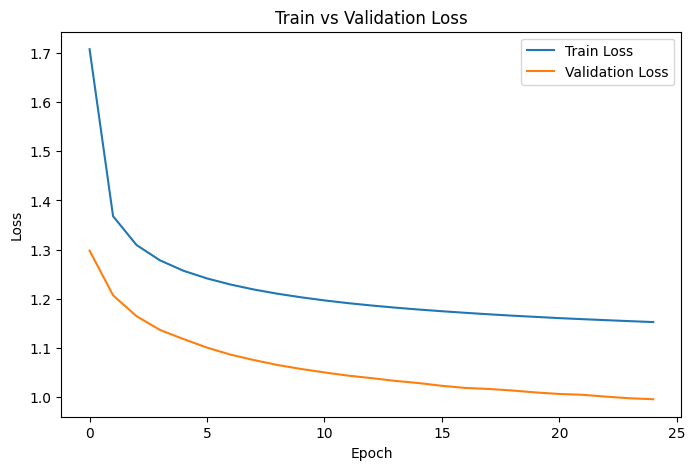

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()
